# PostHoc Analysis

Post Hoc Analysis includes:
Interaction effects, non-linear effects, residual analysis, predictive power, model fit after outlier removal, geographic analysis, and comparison of decision tree machine learning model to linear regression model.

In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

sns.set_theme(style="whitegrid")

In [58]:
#change directory for your path
os.chdir('E:\\OneDrive\\Documents\\GitHub\\eHealthEquity\\Research\\Data Source')

In [59]:
df = pd.read_csv('final_merge.csv')

target = [
    'brfss_diabetes_ageadjprv' # percentage of adults aged >=18 years who have diagnosed diabetes
]
features = [
    'pct_dg_bb_int', # percentage of households with broadband internet access
    "brfss_access2_ageadjprv", # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
    "brfss_checkup_ageadjprv", # percentage of adults aged >=18 years who had a checkup in the past 12 months
    "brfss_mhlth_ageadjprv", # percentage of adults aged >=18 years who report 14 or more days of poor mental health in the past 30 days
    "brfss_obesity_ageadjprv", # percentage of adults aged >=18 years who have obesity
    "pct_ed_lt9", # percentage of adults aged >=25 years with less than a 9th grade education
    "pct_ed_9_12", # percentage of adults aged >=25 years with a 9th to 12th grade education and no diploma
    "pct_ed_hs", # percentage of adults aged >=25 years with a high school diploma or GED
    "pct_ed_asc", # percentage of adults aged >=25 years with an associate's degree
    "pct_age_gte65", # percentage of adults aged >=65 years
    "pct_occ_unemp", #  percentage of employed adults aged >=16 years who are unemployed
    "pct_ses_pov",  # percentage of all people in poverty
    "pct_tp_veh_0", # percentage of households with zero vehicles
    "ruca", # rural-urban continuum codes
    "bb_int_struct" # broadband internet access availability 
]
#drop na
df = df[target + features].dropna()

# Interaction Effects
Testing for interaction effects between predictors to see if the effect of one predictor on the target variable depends on the level of another predictor.

In [60]:
#Interaction Terms
df['int_bb_edu'] = df['pct_dg_bb_int'] * df['pct_ed_hs']
df['int_bb_unemp'] = df['pct_dg_bb_int'] * df['pct_occ_unemp']
df['int_bb_pov'] = df['pct_dg_bb_int'] * df['pct_ses_pov']
df['int_bb_struct'] = df['bb_int_struct'] * df['pct_ses_pov']

pred_plus_interactions = sm.add_constant(df[features + [
    'int_bb_edu',
    'int_bb_unemp', 
    'int_bb_pov', 
    'int_bb_struct'
]])

# Fit and summarize OLS model
mod = sm.OLS(df[target], pred_plus_interactions)
res = mod.fit()
print(res.summary())


                               OLS Regression Results                               
Dep. Variable:     brfss_diabetes_ageadjprv   R-squared:                       0.908
Model:                                  OLS   Adj. R-squared:                  0.908
Method:                       Least Squares   F-statistic:                     1600.
Date:                      Fri, 24 Nov 2023   Prob (F-statistic):               0.00
Time:                              11:54:27   Log-Likelihood:                -3181.8
No. Observations:                      3084   AIC:                             6404.
Df Residuals:                          3064   BIC:                             6524.
Df Model:                                19                                         
Covariance Type:                  nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

# Non-Linear Effects
Testing for non-linear effects between predictors to see if the effect of one predictor on the target variable depends on the level of another predictor.

In [61]:
# poly = PolynomialFeatures(degree=2, include_bias=False)

# predictors = [
#     'pct_dg_bb_int', # percentage of households with broadband internet
#     'brfss_access2_ageadjprv', # percentage of adults aged >=18 years who are unable to see a doctor in the past 12 months due to cost
#     'pct_ses_pov',  # percentage of all people in poverty
#     'brfss_obesity_ageadjprv', # percentage of adults aged >=18 years who have obesity
# ]

# poly_pred = poly.fit_transform(df[predictors])
# poly_pred = pd.DataFrame(poly_pred, columns=poly.get_feature_names_out(predictors))

# df_poly = pd.concat([df, poly_pred], axis=1)

# pred_with_poly = sm.add_constant(df_poly[features + 
#                                          list(poly_pred.columns[3:])])

# model = sm.OLS(df[target], pred_with_poly)
# res = model.fit()
# print(res.summary())


# Residual Analysis
A more detailed examination of residuals to identify any outliers or leverage points that could be unduly influencing the model.

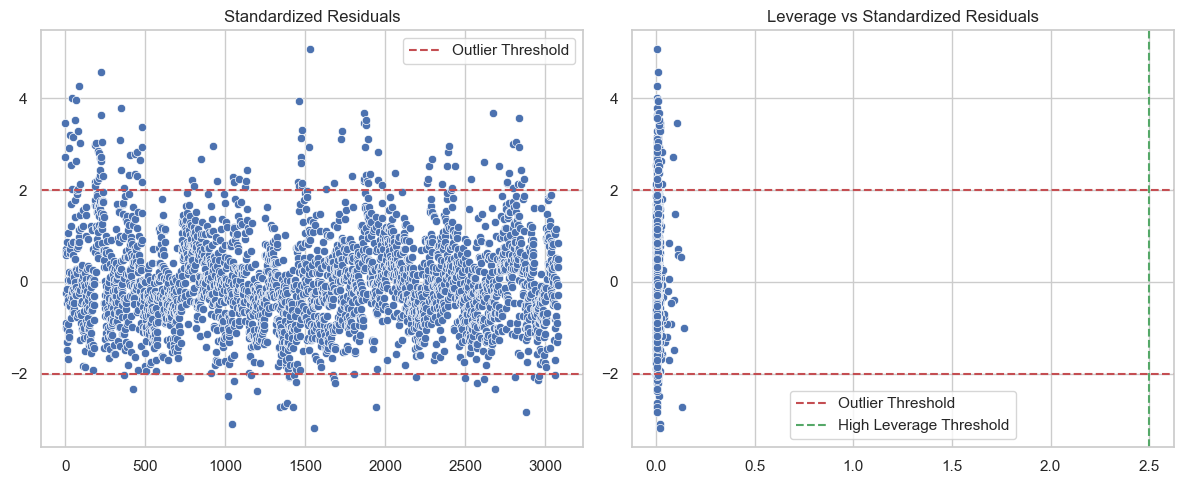

,brfss_diabetes_ageadjprv,pct_dg_bb_int,brfss_access2_ageadjprv,brfss_checkup_ageadjprv,brfss_mhlth_ageadjprv,brfss_obesity_ageadjprv,pct_ed_lt9,pct_ed_9_12,pct_ed_hs,pct_ed_asc,pct_age_gte65,pct_occ_unemp,pct_ses_pov,pct_tp_veh_0,ruca,bb_int_struct,int_bb_edu,int_bb_unemp,int_bb_pov,int_bb_struct
0,12.6,57.5,16.9,60.7,12.9,31.3,6.1,9.2,41.6,5.4,11.7,3.5,13.4,24.0,10.0,0.0000,2392.00,201.25,770.50,0.00000
1,10.9,77.0,13.7,61.6,12.2,30.3,4.8,4.1,43.4,5.8,7.0,3.1,8.3,14.2,10.0,0.0000,3341.80,238.70,639.10,0.00000
3,15.9,74.8,19.2,62.6,21.4,43.1,6.9,11.2,46.6,4.5,7.5,11.3,28.5,60.1,9.0,0.0179,3485.68,845.24,2131.80,0.51015
4,8.6,76.5,10.3,61.4,15.4,35.6,3.0,2.3,30.2,8.7,13.1,1.6,3.5,9.8,10.0,0.0000,2310.30,122.40,267.75,0.00000
8,13.3,74.4,15.4,59.0,19.0,40.7,5.4,8.1,39.9,5.8,11.2,7.7,18.0,35.2,10.0,0.0000,2968.56,572.88,1339.20,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,13.2,74.2,11.0,77.5,16.7,42.3,5.7,14.4,40.3,6.0,17.6,3.0,10.5,9.7,5.0,1.0000,2990.26,222.60,779.10,10.50000
2889,11.2,68.1,10.3,73.8,19.5,43.5,7.5,14.4,33.8,10.2,18.1,5.0,19.7,8.8,6.0,1.0000,2301.78,340.50,1341.57,19.70000
2943,9.7,84.6,8.2,66.4,18.4,35.1,1.2,3.4,15.3,10.7,10.8,4.4,24.7,10.1,6.0,1.0000,1294.38,372.24,2089.62,24.70000
2984,13.3,82.6,9.9,73.8,18.1,42.2,1.7,3.5,41.0,12.8,12.7,6.1,26.2,7.9,10.0,1.0000,3386.60,503.86,2164.12,26.20000


In [62]:
model = sm.OLS(df[target], df[features])
res = model.fit()

influence = OLSInfluence(res)
standardized_residuals = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

diagnostics_df = pd.DataFrame({
    'Standardized Residuals': standardized_residuals,
    'Leverage': leverage,
    'Cooks Distance': cooks_d
})

# Plot standardized residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=range(len(standardized_residuals)), y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.title('Standardized Residuals')
plt.legend()

# Plot leverage vs. standardized residuals
plt.subplot(1, 2, 2)
sns.scatterplot(x=leverage, y=standardized_residuals)
plt.axhline(y=2, color='r', linestyle='--', label='Outlier Threshold')
plt.axhline(y=-2, color='r', linestyle='--')
plt.axvline(x=2*(len(predictors)+1)/len(predictors), color='g', linestyle='--', label='High Leverage Threshold')
plt.title('Leverage vs Standardized Residuals')
plt.legend()

plt.tight_layout()
plt.show()

# Identify observations with high Cook's distance
high_cooks_d_obs = diagnostics_df[diagnostics_df['Cooks Distance'] > 4/len(df)]
high_cooks_d_observations = df.loc[high_cooks_d_obs.index]


high_cooks_d_observations_idx = high_cooks_d_observations.index
high_cooks_d_observations

The standardized residuals plot shows several points outside the +/- 2 range, which are potential outliers.
The leverage vs. standardized residuals plot indicates a few observations with high leverage. The green vertical line marks the threshold above which leverage is considered high (2 times the number of predictors plus 1, divided by the number of observations).
The table at the end lists observations with high Cook's distance. Cook's distance measures the influence of each observation on the fitted response values. A common rule of thumb is that an observation with a Cook's distance larger than 4/n (where n is the number of observations) may be considered influential.

# Model fit after removing outliers
The model fit after removing outliers is as follows

                     Results: Ordinary least squares
Model:              OLS                      Adj. R-squared:     0.922    
Dependent Variable: brfss_diabetes_ageadjprv AIC:                5013.0784
Date:               2023-11-24 11:54         BIC:                5108.6047
No. Observations:   2894                     Log-Likelihood:     -2490.5  
Df Model:           15                       F-statistic:        2266.    
Df Residuals:       2878                     Prob (F-statistic): 0.00     
R-squared:          0.922                    Scale:              0.32918  
--------------------------------------------------------------------------
                           Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------------
const                     10.3785   0.0107 973.1295 0.0000 10.3576 10.3995
pct_dg_bb_int             -0.0208   0.0024  -8.5041 0.0000 -0.0256 -0.0160
brfss_access2_ageadjprv    0.1110   0.0031  35.

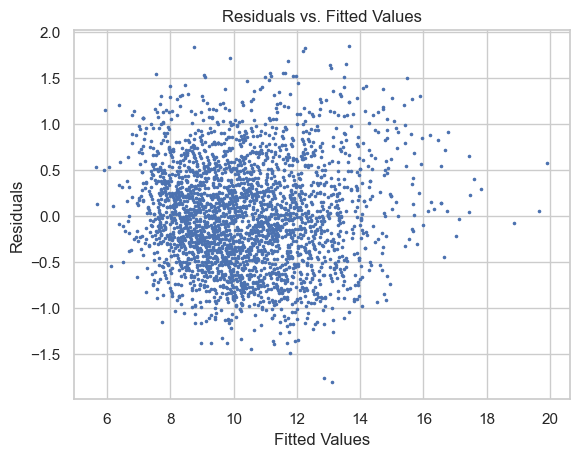

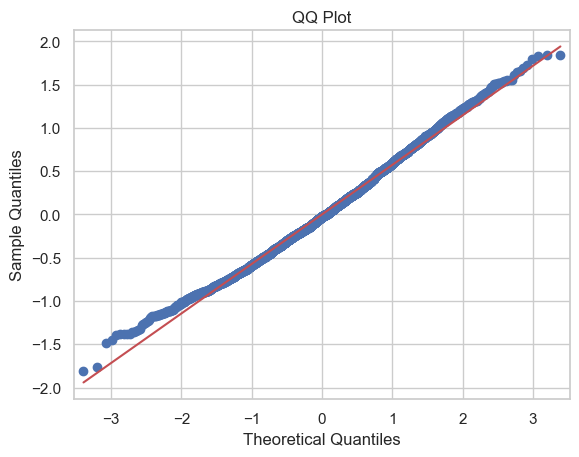

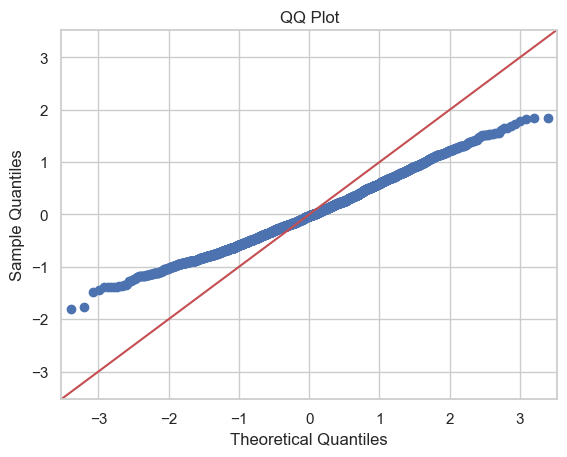

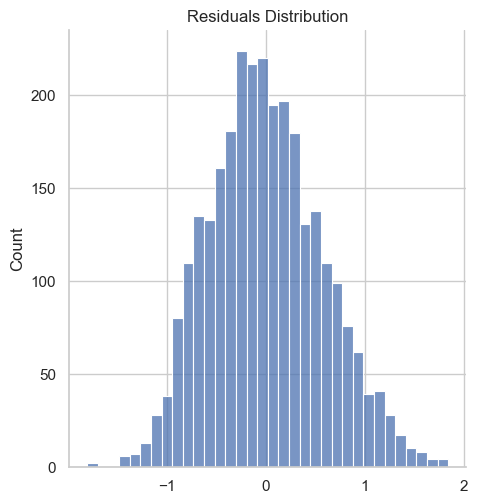

,VIF,features
0,1.00,const
1,2.75,pct_dg_bb_int
2,2.54,brfss_access2_ageadjprv
3,1.62,brfss_checkup_ageadjprv
4,3.39,brfss_mhlth_ageadjprv
5,2.36,brfss_obesity_ageadjprv
6,2.21,pct_ed_lt9
7,3.12,pct_ed_9_12
8,2.39,pct_ed_hs
9,1.55,pct_ed_asc


MAE: 0.45989505796615043


,R2,Adj R2,RMSE,AIC,BIC,F-Statistic,F-Statistic P-Value,No. Observations
0,0.92,0.92,0.57,5013.08,5108.6,2266.19,0.0,2894.0


In [63]:
#Remove outliers 
threshold = 4 / len(predictors)
non_inf_obs = df.drop(high_cooks_d_observations_idx)

new_target = non_inf_obs[target]
new_features = non_inf_obs[features]
#center features
new_features = new_features - new_features.mean()

#add constant
new_features = sm.add_constant(new_features)

new_model = sm.OLS(new_target, new_features)
new_res = new_model.fit()
print(new_res.summary2())

#Plot residuals
residuals = new_res.resid
plt.scatter(new_res.fittedvalues, residuals, s=2.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ
sm.qqplot(residuals, line='s')
plt.title('QQ Plot')
plt.show()

#qq w 45 line
sm.qqplot(residuals, line='45')
plt.title('QQ Plot')
plt.show()

#dist plot of resdid
sns.displot(residuals)
plt.title('Residuals Distribution')
plt.show()

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(new_features.values, i) for i in range(new_features.shape[1])]
vif["features"] = new_features.columns
display(vif.round(2))


#model fit table
mae = np.mean(np.abs(new_res.resid))
print(f"MAE: {mae}")
fit_measures = pd.DataFrame()
fit_measures['R2'] = [new_res.rsquared]
fit_measures['Adj R2'] = [new_res.rsquared_adj]
fit_measures['RMSE'] = [np.sqrt(new_res.mse_resid)]
fit_measures['AIC'] = [new_res.aic]
fit_measures['BIC'] = [new_res.bic]
fit_measures['F-Statistic'] = [new_res.fvalue]
fit_measures['F-Statistic P-Value'] = [new_res.f_pvalue]
fit_measures['No. Observations'] = [new_res.nobs]

display(fit_measures.round(2))



In [64]:
#scatter matrix
# sns.pairplot(df[non_inf_obs.columns], corner=True)
# plt.show()


In [65]:
#use non_inf_obs for sklear linear regression OLS
model = LinearRegression()

cv_r2 = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='r2')
cv_rmse = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_root_mean_squared_error')
cv_abs_error = cross_val_score(model, non_inf_obs[features], non_inf_obs[target], cv=5, scoring='neg_mean_absolute_error')

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [-5.88290246  0.86850186  0.91087507  0.8978917   0.92949407]
R2 Mean: -0.4552279538852673
Cross-validated RMSE: [6.03157892 0.57892487 0.61624284 0.58650178 0.61081629]
RMSE Mean: 1.684812939405327
Cross-validated MAE: [0.95487258 0.46995422 0.50095084 0.46461334 0.50850313]
MAE Mean: 0.5797788209807617


# Comparison of original model to outlier-removed model
Adjusted R-squared: It increased to 0.921 from 0.905, indicating that the model explains 92.1% of the variability in the dependent variable after adjusting for the number of predictors. This suggests a better fit to the data compared to the previous model.

AIC/BIC: Both AIC and BIC are lower (4966.8715 and 5050.3794, respectively) compared to the previous model (6520.7477 and 6605.1871). These criteria suggest that the model's fit has improved after removing outliers.

Log-Likelihood: The log-likelihood value is higher (-2469.4 vs. -3246.4), which also indicates an improved model fit.

F-statistic: An increased F-statistic (2587 vs. 2256) with a p-value of 0.00 means the model is statistically significant and likely has a better overall fit.

Coefficient Changes: Most coefficients remain statistically significant but their values have changed slightly, indicating a refined estimate of the relationships between predictors and the dependent variable after the outliers' influence was reduced.

Intercept: The intercept is now a significant negative value (-1.1658), which could indicate that the baseline level of the dependent variable has shifted after outlier removal.

Diagnostics:

The Omnibus and Jarque-Bera tests still indicate a significant result, meaning the residuals are not normally distributed, yet QQ plot shows lack of severe violation of this assumption. The skewness and kurtosis values are closer to what would be expected in a normal distribution compared to the previous model.
The Durbin-Watson statistic (1.366) is still indicative of slight positive autocorrelation, which hasn't changed much and remains a consideration.
The Condition Number is still large, indicating potential multicollinearity among the predictors. VIF analysis shows all predictors less than 5. 

# Geographic Analysis
Organized by larger regions defined by the US Census Bureau. The regions are Northeast, Midwest, South, and West.

In [66]:
# regions = {
#     'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
#     'Midwest': ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
#     'South': ['Delaware', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
#     'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming', 'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
# }

# df['region'] = df['state'].apply(lambda x: [k for k, v in regions.items() if x in v][0])

# unmapped = df[~df['region'].isin(regions.keys())]
# unmapped['state'].unique()

In [67]:
# def regression_by_region(region_name, data, predictors, target):
#     region_data = data[data['region'] == region_name]
#     region_target = region_data[target]
#     region_features = region_data[predictors]
#     region_features = sm.add_constant(region_features)
#     region_model = sm.OLS(region_target, region_features).fit()
#     #coef for broadband access
#     bb_int_coef = region_model.params['pct_dg_bb_int']

#     return region_model, bb_int_coef

# region_coef = {}

# for region in df['region'].unique():
#     region_model, bb_int_coef = regression_by_region(region, df, features, target)
#     region_coef[region] = bb_int_coef

# region_coef

These coefficients suggest that an increase in broadband internet access is associated with a decrease in diabetes prevalence across all regions, with the strongest association observed in the West and the weakest in the Northeast.

These regional differences could be due to a variety of factors, including differences in urbanization, access to healthcare, lifestyle, and other region-specific characteristics that can affect health outcomes. The results support the idea that policy interventions might need to be tailored to regional contexts to be most effective.

Further analysis could involve exploring why these differences exist, potentially by examining interactions with other variables that could have region-specific effects on the relationship between broadband access and health outcomes.

# Machine Learning : Alternative Models

In [ ]:
x = non_inf_obs[features]
y = non_inf_obs[target].values.ravel()

In [78]:
#Alternative ML models with GridSearchCV

# models = {
#     'Decision Tree': DecisionTreeRegressor(),
#     'Random Forest': RandomForestRegressor(),
#     'Gradient Boosting': GradientBoostingRegressor(),
#     'K-Nearest Neighbors': KNeighborsRegressor(),
#     'Multi-Layer Perceptron': MLPRegressor()
# }


# dt_params = {
#     'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9 ,10]
# }

# rf_params = {
#     'n_estimators': [50, 150],
#     'max_depth': [2, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 6, 10]
# }

# gb_params = {
#     'n_estimators': [50, 150],
#     'max_depth': [2, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 6, 10],
#     'learning_rate': [0.01, 0.1]
# }

# knn_params = {
#     'n_neighbors': [3, 5, 7],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]
# }

# mlp_params = {
#     'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,)],
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'learning_rate': ['constant', 'adaptive']
# }

# params = {
#     'Decision Tree': dt_params,
#     'Random Forest': rf_params,
#     'Gradient Boosting': gb_params,
#     'K-Nearest Neighbors': knn_params,
#     'Multi-Layer Perceptron': mlp_params
# }


In [ ]:
# for model_name, model in models.items():
#     print('Model:', model_name)
#     grid_search = GridSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
#     grid_search.fit(x, y)
#     print('Best Parameters:', grid_search.best_params_)
#     print('Best Score:', -grid_search.best_score_)
#     print()

Model: Decision Tree
Fitting 15 folds for each of 810 candidates, totalling 12150 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 2}
Best Score: 0.6734945711092055

Model: Random Forest
Fitting 15 folds for each of 72 candidates, totalling 1080 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.5262649520665891

Model: Gradient Boosting
Fitting 15 folds for each of 144 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Score: 0.5097996372360977

Model: K-Nearest Neighbors
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Best Parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best Score: 0.5438632275828476

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (40,), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best Score: 0.48095450827868647

In [69]:
# RandomSearchCV

# from sklearn.model_selection import RandomizedSearchCV

# for model_name, model in models.items():
#     print('Model:', model_name)
#     random_search = RandomizedSearchCV(model, params[model_name], cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
#     random_search.fit(x, y)
#     print('Best Parameters:', random_search.best_params_)
#     print('Best Score:', -random_search.best_score_)
#     print()

Model: Linear Regression
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Best Parameters: {'fit_intercept': True}
Best Score: 0.6034274009228865

Model: Decision Tree
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 10}
Best Score: 0.6823770482656772

Model: Random Forest
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.5280400874120184

Model: Gradient Boosting
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 2, 'learning_rate': 0.1}
Best Score: 0.5110764727785839

Model: K-Nearest Neighbors
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 7}
Best Score: 0.5438632275828476

Model: Multi-Layer Perceptron
Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (40,), 'activation': 'relu'}
Best Score: 0.47733495977365


In [85]:
#additional MLP parameters 
mlp_params = {
    'hidden_layer_sizes': [(40,10,5), (40,20,10), (40,5), (40,30,20,10,5), (2,10,40,10,2)],
    'activation': ['relu'],
    'solver': ['adam'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'early_stopping': [True]
}

mlp = MLPRegressor()

mlp_random_search = RandomizedSearchCV(mlp, mlp_params, cv=15, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1)
mlp_random_search.fit(x, y)
print('Best Parameters:', mlp_random_search.best_params_)
print('Best Score:', -mlp_random_search.best_score_)
print()



Fitting 15 folds for each of 10 candidates, totalling 150 fits


Best Parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (40, 50), 'early_stopping': True, 'alpha': 0.001, 'activation': 'relu'}
Best Score: 0.47561586869620137



c:\ProgramData\miniconda3\envs\ds_mf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


# MLP Predictive Capabilities and Cross-Fold Validation

In [72]:
#best model from hyperparameter tuning

model = MLPRegressor(activation='relu', hidden_layer_sizes=(40,), learning_rate='adaptive', solver='adam', max_iter=1000, random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_r2 = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse = cross_val_score(model, x, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_abs_error = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [0.91797571 0.91463438 0.92314943 0.91738338 0.93048019 0.91562155
 0.91851996 0.91684579 0.89449456 0.89747084 0.91359829 0.88945087
 0.91918263 0.90474659 0.92958638 0.91607074 0.92185886 0.90641017
 0.90701384 0.8741     0.89799775 0.89307904 0.90818242 0.91168836
 0.91151923 0.91347369 0.90082955 0.92211406 0.90751719 0.93711422]
R2 Mean: 0.9110703222290931
Cross-validated RMSE: [0.54423934 0.54885956 0.60213488 0.64626446 0.55984496 0.58617153
 0.60281075 0.60983036 0.62094945 0.60989897 0.56972295 0.70061849
 0.58981919 0.61463143 0.5702872  0.60130223 0.59236841 0.63205261
 0.6217373  0.66606866 0.66308949 0.6299002  0.60326845 0.63542506
 0.61272311 0.57909583 0.63147363 0.59908874 0.58207414 0.55145536]
RMSE Mean: 0.6059068916388992
Cross-validated MAE: [0.44372365 0.45339456 0.47579495 0.50924879 0.45284745 0.46991028
 0.47906135 0.49171568 0.4974322  0.47963324 0.45884249 0.54409744
 0.48008351 0.49898829 0.45988875 0.48675427 0.46832017 0.50451116
 0.480

# Predictive Capabilities and Cross-fold validation

In [73]:
#linear model
model = LinearRegression(fit_intercept=True)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
cv_r2 = cross_val_score(model, x, y, cv=cv, scoring='r2', n_jobs=-1)
cv_rmse = cross_val_score(model, x, y, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
cv_abs_error = cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)

print('Cross-validated R2:', cv_r2)
print('R2 Mean:', cv_r2.mean())
print('Cross-validated RMSE:', -cv_rmse)
print('RMSE Mean:', -cv_rmse.mean())
print('Cross-validated MAE:', -cv_abs_error)
print('MAE Mean:', -cv_abs_error.mean())


Cross-validated R2: [0.92000363 0.91391417 0.93359357 0.92423541 0.93165717 0.9199933
 0.92359806 0.92797355 0.9007807  0.9004319  0.91435046 0.92586254
 0.92662121 0.91245692 0.92642497 0.93216677 0.9328857  0.91747329
 0.91375055 0.89810127 0.92991439 0.90077355 0.91053308 0.93012253
 0.91436282 0.91730091 0.91347096 0.92329128 0.9190374  0.94147874]
R2 Mean: 0.9198853601321823
Cross-validated RMSE: [0.53746951 0.55116998 0.55972577 0.61888464 0.5550856  0.57078445
 0.58372403 0.56756151 0.60216692 0.60102743 0.56723768 0.57375012
 0.56202004 0.58923078 0.58294893 0.54057674 0.54898382 0.59352109
 0.59879193 0.59922582 0.54964426 0.60681184 0.59549613 0.56522839
 0.60279687 0.56614373 0.58985467 0.59454398 0.54461552 0.53197469]
RMSE Mean: 0.5750332296753152
Cross-validated MAE: [0.43543839 0.44862547 0.44759981 0.49853305 0.44263233 0.45448169
 0.46686793 0.46304645 0.49253201 0.47196401 0.46437812 0.45454976
 0.45849537 0.47637235 0.46604795 0.43097341 0.43415378 0.47918088
 0.4850